In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
- drop unnecessary columns
- drop duplicates
- manage outliers
- manage null values
---
- combine cats and dogs in to a single column (pets_allowed maybe?)
- encode 'region', 'type', 'laundry_options', 'parking_options', 'state' categorical features

encoding "region" might be unnecessary, but we will see

In [2]:
df = pd.read_csv("housing_train.csv")

In [3]:
df.head(2)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,...,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       265190 non-null  int64  
 1   url                      265190 non-null  object 
 2   region                   265190 non-null  object 
 3   region_url               265190 non-null  object 
 4   price                    265190 non-null  int64  
 5   type                     265190 non-null  object 
 6   sqfeet                   265190 non-null  int64  
 7   beds                     265190 non-null  int64  
 8   baths                    265190 non-null  float64
 9   cats_allowed             265190 non-null  int64  
 10  dogs_allowed             265190 non-null  int64  
 11  smoking_allowed          265190 non-null  int64  
 12  wheelchair_access        265190 non-null  int64  
 13  electric_vehicle_charge  265190 non-null  int64  
 14  come

In [5]:
df.isna().sum()

id                             0
url                            0
region                         0
region_url                     0
price                          0
type                           0
sqfeet                         0
beds                           0
baths                          0
cats_allowed                   0
dogs_allowed                   0
smoking_allowed                0
wheelchair_access              0
electric_vehicle_charge        0
comes_furnished                0
laundry_options            54311
parking_options            95135
image_url                      0
description                    2
lat                         1419
long                        1419
state                          1
dtype: int64

---

## Dropping columns and duplicates

#### Dropping Irrelevant Columns

In [6]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')

In [7]:
df = df.drop(columns=["id", "url", "region_url", "image_url"])

#### Dropping Duplicates

In [8]:
df[df.duplicated()].head(2)

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,description,lat,long,state
45,birmingham,659,apartment,890,2,1.0,1,1,1,0,0,0,laundry on site,NaN,Are you looking for a quiet place to call home...,33.6493,-86.7057,al
46,birmingham,659,apartment,890,2,1.0,1,1,1,0,0,0,laundry on site,NaN,Are you looking for a quiet place to call home...,33.6493,-86.7057,al


In [9]:
df.duplicated().sum()

47216

lots of duplicated rows

In [10]:
# before dropping duplicates
df.shape[0]

265190

In [11]:
df = df.drop_duplicates(keep="first")

In [12]:
# after dropping duplicates
df.shape[0]

217974

---

## Outliers

price, sqfeet, beds, baths columns has outliers

In [13]:
# storing the amount of rows before dropping any outliers
w_outliers = df.shape[0]

In [14]:
# creating some helper functions to use it in every feature

def find_iqr_and_fences(df, feature):
    iqr = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    upper_fence = df[feature].quantile(0.75) + 1.5 * iqr
    lower_fence = df[feature].quantile(0.25) - 1.5 * iqr
    
    print(f"{feature} feature's IQR: {iqr}")    
    print(f"Samples above with value {upper_fence} should be dropped")
    print(f"Amount of outliers detected in upper region: {df[df[feature] > upper_fence].shape[0]}\n")
    
    print(f"Samples below with value {lower_fence} should be dropped")
    print(f"Amount of outliers detected in lower region: {df[df[feature] < lower_fence].shape[0]}")
    
    return lower_fence, upper_fence
    
def outlier_viz(df, feature):
    print(df[feature].describe())
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=80)
    
    gs = ax[0, 0].get_gridspec()
    # # remove the wanted axes
    ax[0, 1].remove()

    axwide = fig.add_subplot(gs[0, 0:])

    axwide.boxplot(df[feature], vert=False)
    axwide.set_title(f"Box Plot of the {feature} feature")

    ax[1, 0].hist(df[feature])
    ax[1, 0].set_title(f"Histogram Plot of the {feature} feature")

    ax[1, 1].plot(df[feature].sort_values().reset_index().drop("index", axis=1))
    ax[1, 1].set_title(f"Sorted Line Plot of the {feature} feature");

    plt.tight_layout()
    plt.show()
    

### price Feature

count    2.179740e+05
mean     1.461851e+04
std      5.929993e+06
min      0.000000e+00
25%      8.500000e+02
50%      1.109000e+03
75%      1.499000e+03
max      2.768307e+09
Name: price, dtype: float64


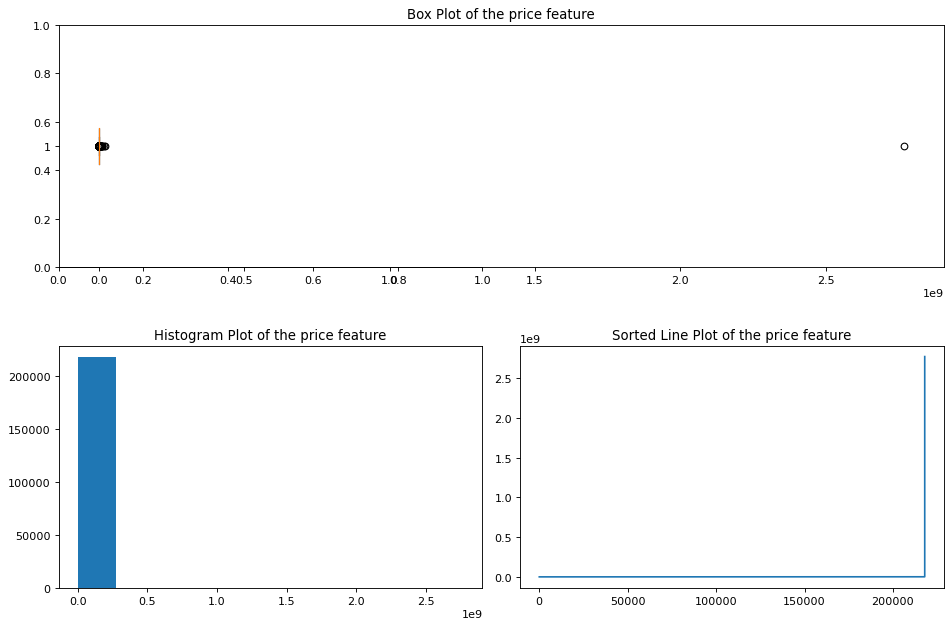

In [15]:
# before dropping outliers
outlier_viz(df, "price")

minimum price of zero is concerning, therefore I am going to investigate the lower bound of this feature first

In [16]:
df[df.price == 0].price

1735      0
1741      0
7049      0
7286      0
8171      0
         ..
264881    0
265094    0
265151    0
265180    0
265185    0
Name: price, Length: 589, dtype: int64

In [17]:
# I set the lower bound to be 400 USD
df[df.price < 400].price

634       344
635       300
641       300
643       344
722       295
         ... 
264965     55
265094      0
265151      0
265180      0
265185      0
Name: price, Length: 2658, dtype: int64

In [18]:
df = df[df.price >= 400]

In [19]:
lower, upper = find_iqr_and_fences(df, "price")

price feature's IQR: 645.0
Samples above with value 2467.5 should be dropped
Amount of outliers detected in upper region: 11057

Samples below with value -112.5 should be dropped
Amount of outliers detected in lower region: 0


count    204259.000000
mean       1170.594304
std         429.736004
min         400.000000
25%         849.000000
50%        1090.000000
75%        1425.000000
max        2467.000000
Name: price, dtype: float64


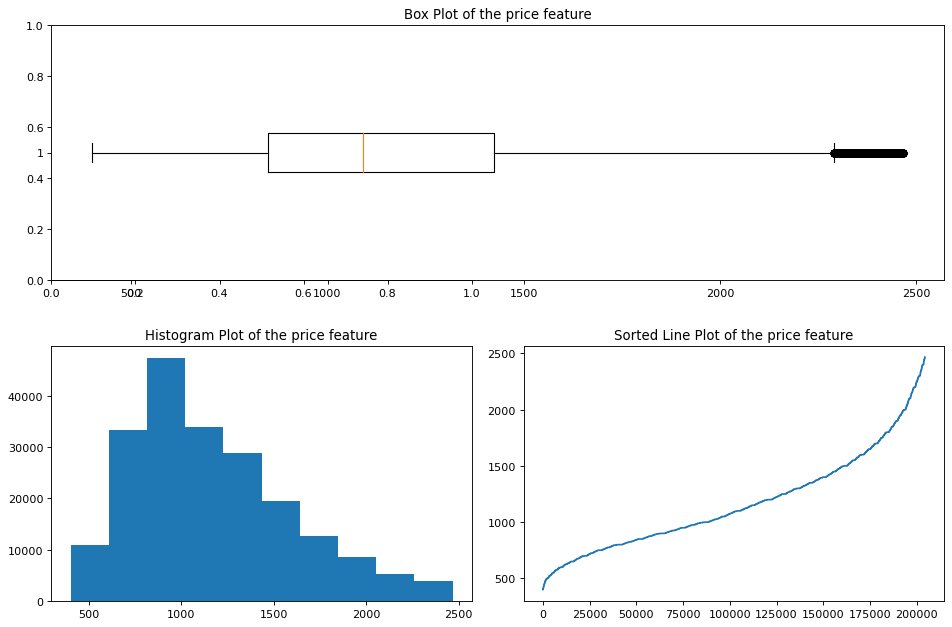

In [20]:
# after dropping outliers
df = df[df.price <= upper]
outlier_viz(df, "price")

### sqfeet Feature

count    2.042590e+05
mean     1.098807e+03
std      2.608873e+04
min      0.000000e+00
25%      7.520000e+02
50%      9.500000e+02
75%      1.150000e+03
max      8.388607e+06
Name: sqfeet, dtype: float64


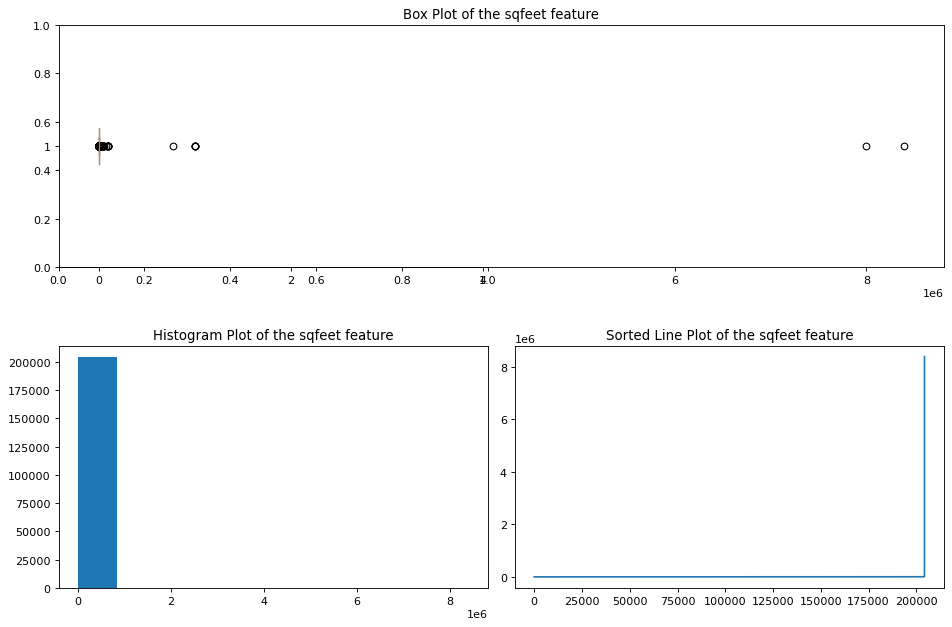

In [21]:
# before dropping outliers
outlier_viz(df, "sqfeet")

In [22]:
df[df.sqfeet < 500].sqfeet

423       230
426       230
681         1
762       300
765       300
         ... 
264818    255
264822    450
264911    430
264922      2
265148    300
Name: sqfeet, Length: 6289, dtype: int64

In [23]:
df = df[df.sqfeet >= 500]

In [24]:
lower, upper = find_iqr_and_fences(df, "sqfeet")

sqfeet feature's IQR: 378.0
Samples above with value 1720.0 should be dropped
Amount of outliers detected in upper region: 7407

Samples below with value 208.0 should be dropped
Amount of outliers detected in lower region: 0


In [25]:
df = df[(lower <= df.sqfeet) & (df.sqfeet <= upper)]

count    190563.000000
mean        964.325430
std         255.417078
min         500.000000
25%         766.000000
50%         950.000000
75%        1121.000000
max        1720.000000
Name: sqfeet, dtype: float64


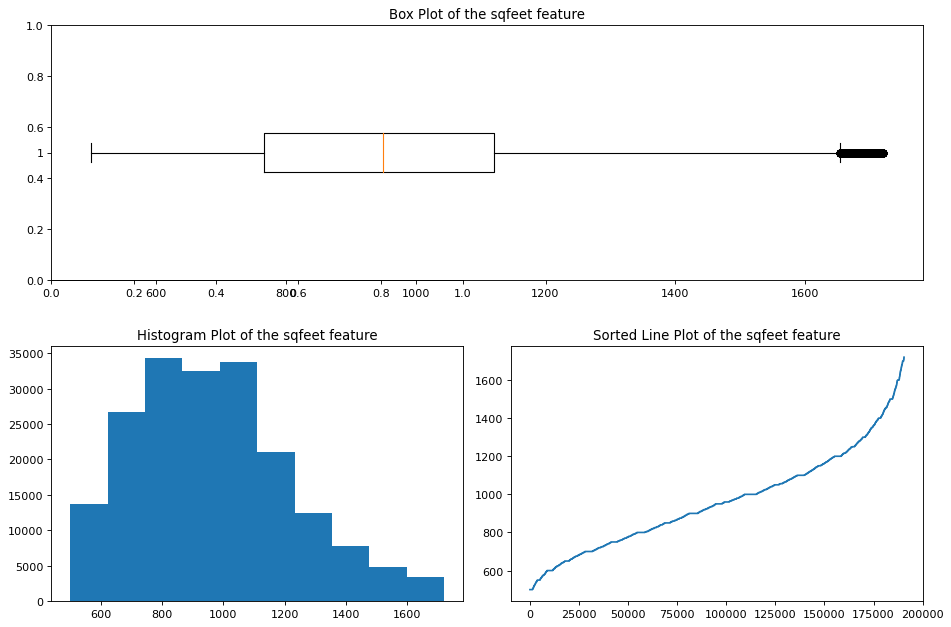

In [26]:
# after dropping outliers
outlier_viz(df, "sqfeet")

### beds Feature

count    190563.000000
mean          1.868101
std           2.633363
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max        1100.000000
Name: beds, dtype: float64


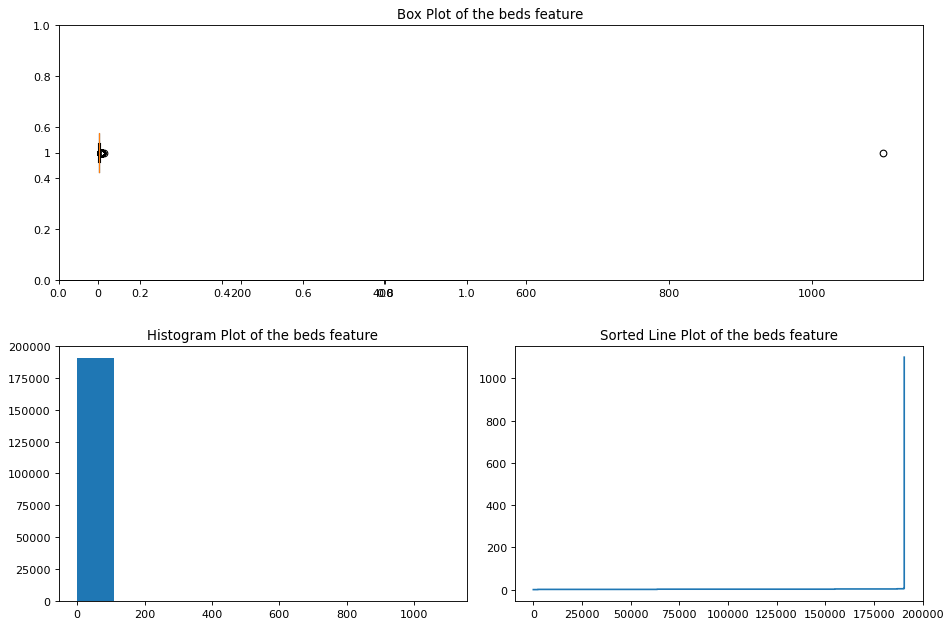

In [27]:
# before dropping outliers
outlier_viz(df, "beds")

In [28]:
lower, upper = find_iqr_and_fences(df, "beds")

beds feature's IQR: 1.0
Samples above with value 3.5 should be dropped
Amount of outliers detected in upper region: 3642

Samples below with value -0.5 should be dropped
Amount of outliers detected in lower region: 0


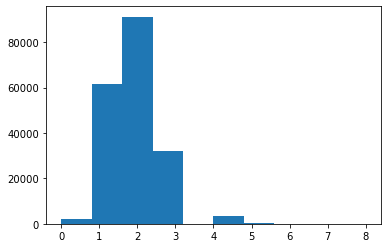

In [29]:
# checking if the upper bound is meaningful
plt.hist(df[df.beds <= 10].beds);

In [30]:
# I am adjusting the upper bound to 5 on the contrast with 3.5 suggested from the outlier detector I implemented 
df = df[(lower <= df.beds) & (df.beds <= 5)]

count    190554.000000
mean          1.862155
std           0.778255
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           5.000000
Name: beds, dtype: float64


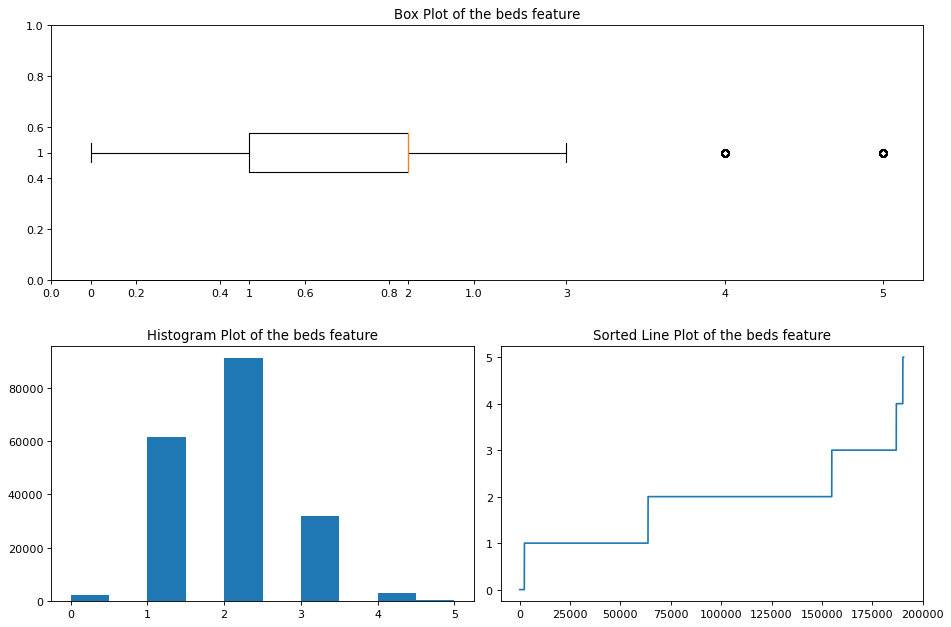

In [31]:
# after dropping outliers
outlier_viz(df, "beds")

### baths Feature

count    190554.000000
mean          1.452675
std           0.550348
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: baths, dtype: float64


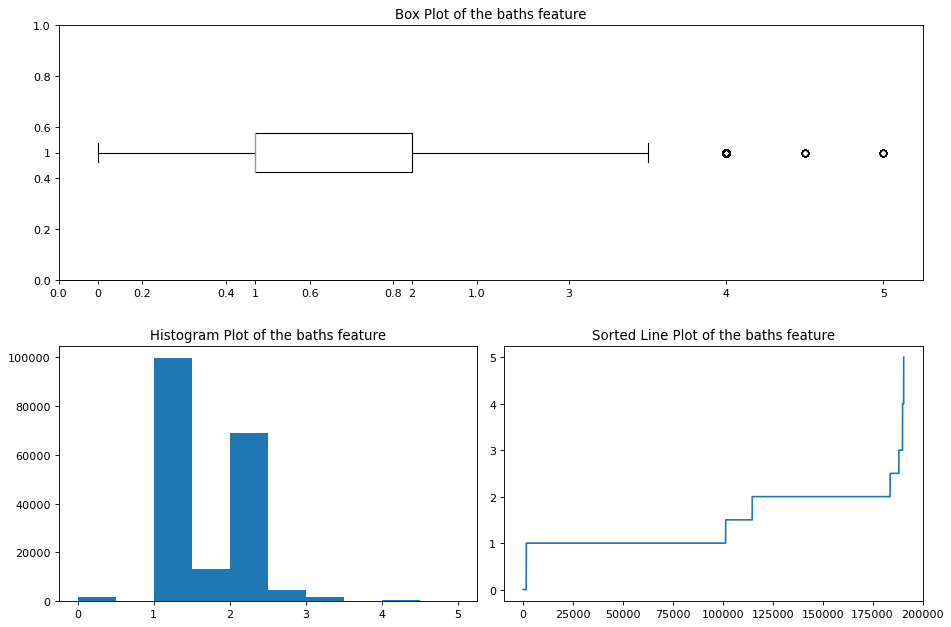

In [32]:
outlier_viz(df, "baths")

- after all of the other outlier reductions, it seems that outliers in baths feature is also affected
- we can skip baths feature due to this fact

#### Total amount of rows dropped during outliers reduction

In [34]:
w_outliers - df.shape[0]

27420

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190554 entries, 1 to 265189
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   region                   190554 non-null  object 
 1   price                    190554 non-null  int64  
 2   type                     190554 non-null  object 
 3   sqfeet                   190554 non-null  int64  
 4   beds                     190554 non-null  int64  
 5   baths                    190554 non-null  float64
 6   cats_allowed             190554 non-null  int64  
 7   dogs_allowed             190554 non-null  int64  
 8   smoking_allowed          190554 non-null  int64  
 9   wheelchair_access        190554 non-null  int64  
 10  electric_vehicle_charge  190554 non-null  int64  
 11  comes_furnished          190554 non-null  int64  
 12  laundry_options          146715 non-null  object 
 13  parking_options          115228 non-null  object 
 14  descripti

---

# Filling Null Values